# Fig. 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 20})
import xarray as xr 
import warnings
import seaborn as sns

import matplotlib.lines as mlines
# Suppress specific warnings
warnings.filterwarnings("ignore")

In [2]:
#Sounding specific functions
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
from metpy.calc import  mixed_layer_cape_cin, most_unstable_cape_cin, cape_cin, surface_based_cape_cin

## Functions

In [3]:
# Function to calculate water vapor pressure
def calc_vapor_pressure(qv, p):
    return (qv * p) / (0.622 + qv)

# Function to calculate dew point
def calc_dew_point(e):
    return (243.12 * np.log(e / 6.112)) / (17.62 - np.log(e / 6.112))


## Get data

### Model Data

In [4]:
data_path = "../data/"
dsref = xr.open_mfdataset(data_path + "exp_ref.nc", engine = 'netcdf4').isel(time = slice(2,None)).mean("time").sel(lat = -36, method = "nearest").sel(lon = 146.5, method = "nearest").squeeze()

infile = "./height_info.nc"
ds = xr.open_mfdataset(infile, engine = 'netcdf4').isel(time=slice(2,None)).mean("time")
z = xr.open_mfdataset("./height_info.nc").mean("time").squeeze().mean(("lat", "lon"))["z_mc"]/1000

In [5]:
# Extract Variables
p = dsref["pres"] / 100
T = dsref["temp"] - 273.15
qv = dsref["qv"]
u = dsref["u"]
v = dsref["v"]

### Observational data

In [6]:
# Load the data
data = np.loadtxt('./obs.txt')

obsP = data[:, 0]  # First column: Pressure
obsT = data[:, 2]  # Second column: Temperature
obsDT = data[:, 3]  # Second column: Dewpoint

## Tropopause height

In [7]:
Tz = T.assign_coords(height=z.values)
zz = z.assign_coords(height=z.values)
pz = p.assign_coords(height=z.values)
# Clip the data to make life easier; the Tropopause will be between 8 and 15 km
Tz = Tz.sel(height = slice(15,8))
zz = zz.sel(height = slice(15,8))
pz = pz.sel(height = slice(15,8))
z_r = zz.values[::-1]
p_r = pz.values[::-1]
tropoheight = 0
tropopres = 0

dTz_dz = Tz.differentiate("height").values[::-1]
for i in range(len(dTz_dz)):
    if dTz_dz[i]>-2:
        tropoheight = (z_r[i-1] + z_r[i])/2
        tropopres = (p_r[i-1] + p_r[i])/2
        print("Tropopause height:")
        print(tropoheight)
        print("Tropopause pressure:")
        print(tropopres)
        break

Tropopause height:
13.42563247680664
Tropopause pressure:
165.97796630859375


## Plot Figure

In [8]:
vapor_pressure = calc_vapor_pressure(qv, p)
dew_point = calc_dew_point(vapor_pressure)
Td = xr.DataArray(dew_point, dims=qv.dims, coords=qv.coords, name='Dew_Point')

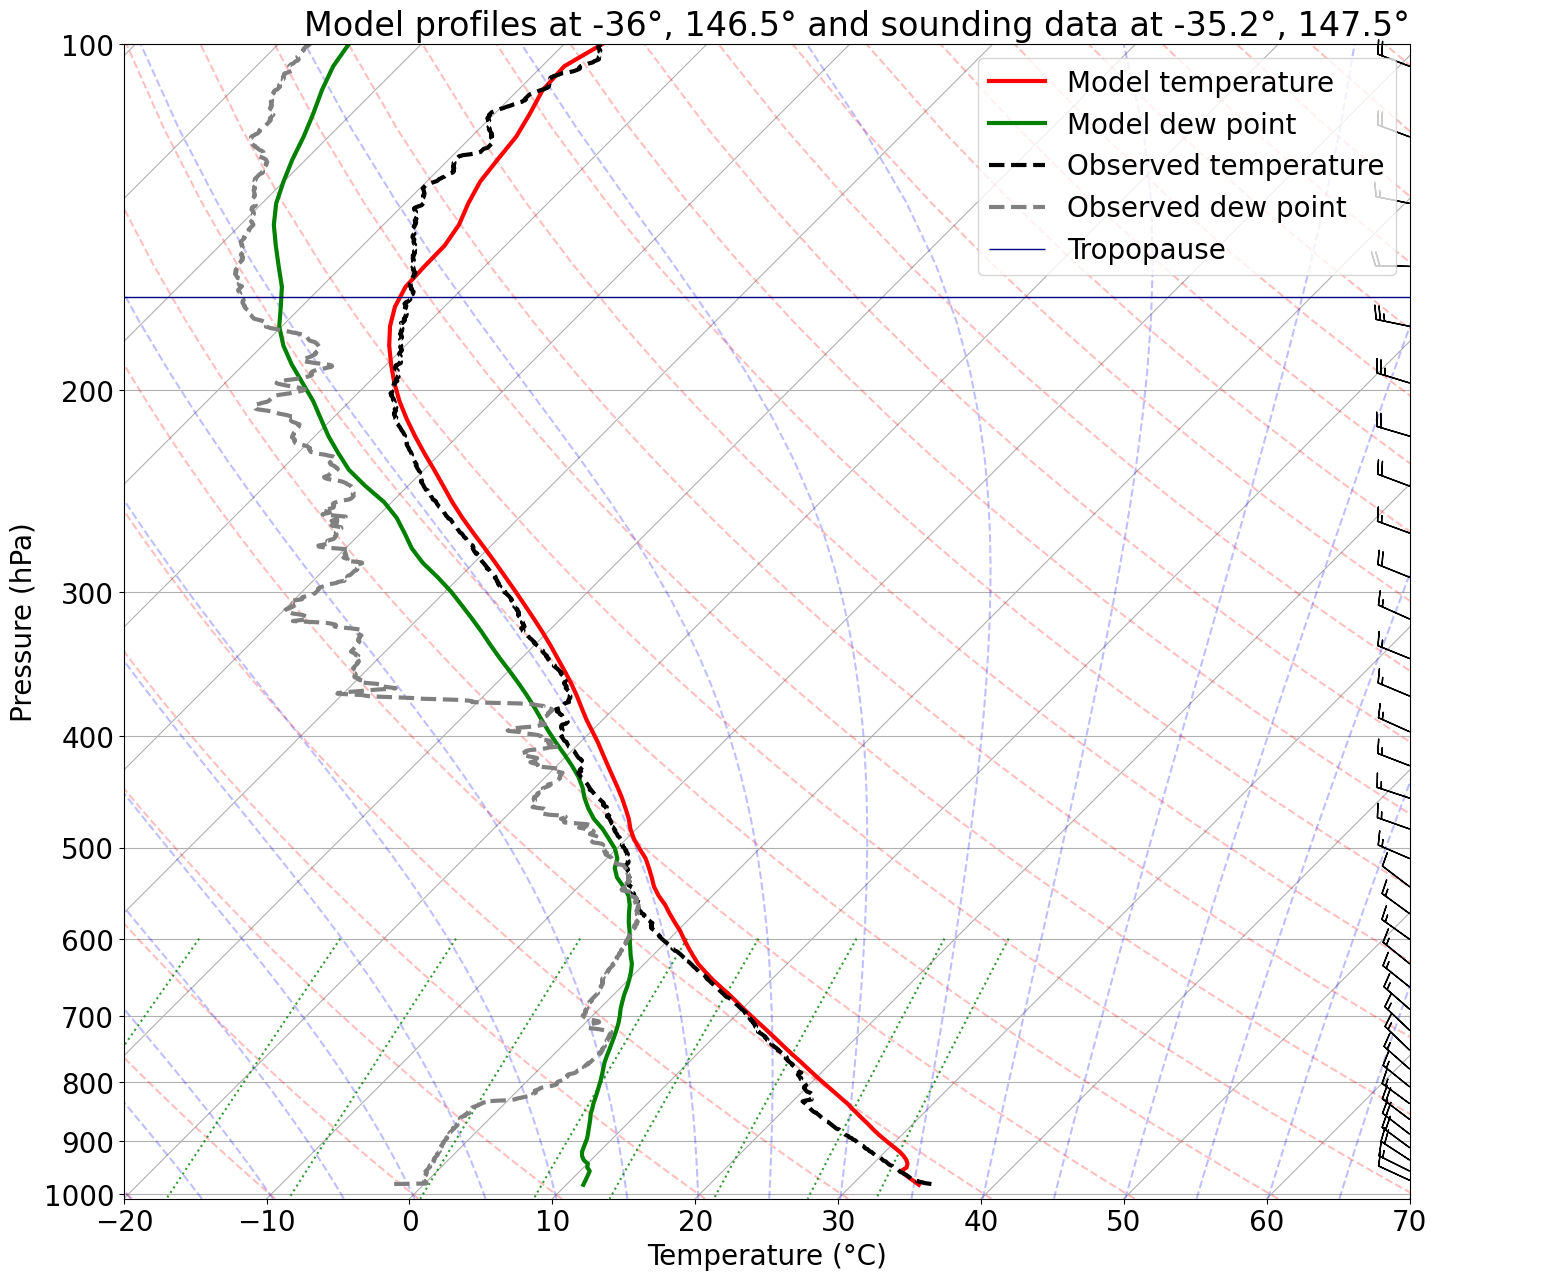

In [9]:
#Initialize the Skew-T plot
fig = plt.figure(figsize=(17, 15))
skew = SkewT(fig, rotation=45)

# Plot model temperature and dew point with labels and custom styling
skew.plot(p, T, 'r', linewidth=3, label="Model temperature")
skew.plot(p, Td, 'g', linewidth=3, label="Model dew point")

# Plot wind barbs at every third pressure level
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)

# Plot observed temperature and dew point with dashed lines
skew.plot(obsP, obsT, "k", linewidth=3, label="Observed temperature", linestyle="--")
skew.plot(obsP, obsDT, "gray", linewidth=3, label="Observed dew point", linestyle="--")

# Set axis limits for temperature (x-axis) and pressure (y-axis)
skew.ax.set_xlim(-20, 70)
skew.ax.set_ylim(1010, 100)

# Add dry adiabats, moist adiabats, and mixing ratio lines
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K, alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K, alpha=0.25, color='tab:green')
skew.plot_mixing_lines(linestyle='dotted', color='tab:blue')

skew.ax.hlines(tropopres, -200, 20, color = "navy", label = "Tropopause", linewidth = 1)
# Add labels, title, and legend
plt.xlabel("Temperature (°C)")
plt.ylabel("Pressure (hPa)")
plt.title("Model profiles at -36°, 146.5° and sounding data at -35.2°, 147.5°", loc="right")
plt.legend()

# Save the figure in both high and low quality
output_path = "./figs/"
plt.savefig(f"{output_path}fig02.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{output_path}fig02_lq.png", dpi=50, bbox_inches='tight')


## Convert tropopause height from hPa to km

In [10]:
def find_height(p,z,p0):
    diff = np.abs(p - p0).compute()
    idx = diff.argmin().item()
    return z[idx].compute().item()

In [11]:
find_height(p,z,200)

12.356989860534668

In [12]:
find_height(p,z,500)

5.842246055603027